In [2]:
import tellurium as te 
import numpy as np 
import matplotlib.pyplot as plt


### excitation and inhibition diction.

In [3]:
excite = {
  'komorova': lambda pop, k: f'{pop}/{k}',
  'lander':   lambda pop, a: f'{pop}/(1+{a}*{pop})',
  'hill':     lambda pop, a, n: f'({pop}^{n})/(1+({a}*{pop})^{n})',

  # the below were created by Copilot and I decided to keep them (aren't they cute? 🥰)
  'hill2':    lambda pop, a, n: f'({pop}^{n})/(1+({a}*{pop})^{n}) + ({pop}**(2*{n}))/(1+({a}*{pop})**(2*{n}))',
  'hill3':    lambda pop, a, n: f'({pop}^{n})/(1+({a}*{pop})^{n}) + ({pop}**(2*{n}))/(1+({a}*{pop})**(2*{n})) + ({pop}**(3*{n}))/(1+({a}*{pop})**(3*{n}))',
  'hill4':    lambda pop, a, n: f'({pop}^{n})/(1+({a}*{pop})^{n}) + ({pop}**(2*{n}))/(1+({a}*{pop})**(2*{n})) + ({pop}**(3*{n}))/(1+({a}*{pop})**(3*{n})) + ({pop}**(4*{n}))/(1+({a}*{pop})**(4*{n}))',
}

inhib = {
  'komorova': lambda pop, k: f'1-({pop}/{k})',
  'lander':   lambda pop, a: f'1/(1+{a}*{pop})',
  'hill':     lambda pop, a, n: f'1/(1+({a}*{pop})^{n})',

  # the below were created by Copilot and I decided to keep them (aren't they cute? 🥰)
  'hill2':    lambda pop, a, n: f'1/(1+({a}*{pop})^{n}) + 1/(1+({a}*{pop})**(2*{n}))',
  'hill3':    lambda pop, a, n: f'1/(1+({a}*{pop})^{n}) + 1/(1+({a}*{pop})**(2*{n})) + 1/(1+({a}*{pop})**(3*{n}))',
  'hill4':    lambda pop, a, n: f'1/(1+({a}*{pop})^{n}) + 1/(1+({a}*{pop})**(2*{n})) + 1/(1+({a}*{pop})**(3*{n})) + 1/(1+({a}*{pop})**(4*{n}))',
}



In [6]:
def twoCompartmentModel(STEM='1', DIFF='0',
                        L='0.5', P='0.5', D='0.1',
                        Control=['1','1'], Events=[]):

    eventString = '\n'.join(Events)

    return  f"""
    # Initialized Populations
    STEM = {STEM};
    DIFF = {DIFF};

    # Rate of Division of Stem Cells
    ES_2S: STEM -> 2STEM; {L} * STEM * ({Control[0]});

    # Rate of Differentiation of Stem Cells
    ES_D:  STEM -> DIFF; {P} * 2 * {L} * STEM * ({Control[1]});

    # Rate of Death of Differentiated Cells
    ED_D: DIFF -> ; {D} * DIFF;

    #Events 
    {eventString}
    """

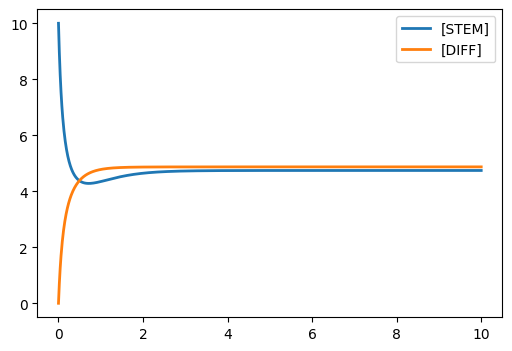

4.74323420462143 4.871616185041754

    # Initialized Populations
    STEM = 10;
    DIFF = 0;

    # Rate of Division of Stem Cells
    ES_2S: STEM -> 2STEM; 2 * STEM * (1-(STEM/5));

    # Rate of Differentiation of Stem Cells
    ES_D:  STEM -> DIFF; 1 * 2 * 2 * STEM * (1-(DIFF/5));

    # Rate of Death of Differentiated Cells
    ED_D: DIFF -> ; 0.1 * DIFF;

    #Events
    
    

vES_2S = 2*STEM*(1-STEM/5)
vES_D = 1*2*2*STEM*(1-DIFF/5)
vED_D = 0.1*DIFF

dSTEM/dt = vES_2S - vES_D
dDIFF/dt = vES_D - vED_D



In [5]:
model = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='2',P='1',D='0.1',
  Control=[inhib['komorova']('STEM','5'), inhib['komorova']('DIFF','5'), '1'], 
  Events=[])
# print(model)
r = te.loada(model)
s = r.simulate(0, 10, 1000) #, ['time','STEM','DIFF'])
r.plot(s)

# r.getSteadyStateValues()
print(r.STEM, r.DIFF)
print(model)
print(te.getODEsFromModel(r))

In [7]:
def threeCompartmentModel(STEM='1', INTER='0', DIFF='0',
                        LS='0.5', PS='0.5', 
                        LI='0.5', PI='0.5',
                        D='0.1',
                        Control=['1','1','1','1'], Events=[]):

    eventString = '\n'.join(Events)

    return  f"""
    # Initialized Populations
    STEM = {STEM};
    INTER = {INTER};
    DIFF = {DIFF};

    # DIVISION RATE OF STEM CELLS
    LS = {LS};

    # Rate of Division of Stem Cells
    ES_2S: STEM -> 2STEM; LS * STEM * ({Control[0]});

    # Rate of Differentiation of Stem Cells
    ES_I:  STEM -> INTER; {PS} * 2 * {LS} * STEM * ({Control[1]});

    # Rate of Division of Intermediate Cells
    EI_2I: INTER -> 2INTER; {LI} * STEM * ({Control[2]});

    # Rate of Differentiation of Intermediate Cells
    ES_D:  INTER -> DIFF; {PI} * 2 * {LI} * STEM * ({Control[3]});

    # Rate of Death of Differentiated Cells
    ED_D: DIFF -> ; {D} * DIFF;

    #Events
    {eventString}
    """

Biologically realistic topology: 

Topology #1

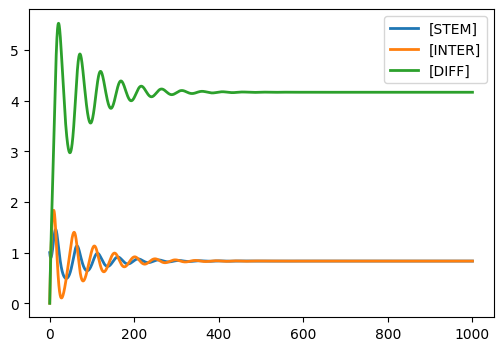


vES_2S = LS*STEM*(1-STEM/5)
vES_I = 0.5*2*0.5*STEM*(1-INTER/5)
vEI_2I = 0.5*STEM*(1-DIFF/5)
vES_D = 0.5*2*0.5*STEM*1
vED_D = 0.1*DIFF

dSTEM/dt = vES_2S - vES_I
dINTER/dt = vES_I + vEI_2I - vES_D
dDIFF/dt = vES_D - vED_D



In [8]:
model = threeCompartmentModel(
  STEM='1', INTER='0', DIFF='0', 
  LS='0.5',PS='0.5',LI='0.5',PI='0.5',D='0.1',
  Control=[inhib['komorova']('STEM','5'), inhib['komorova']('INTER','5'), inhib['komorova']('DIFF','5'), '1',],
  Events=[])

r = te.loada(model)
r.simulate(0, 1000, 10000)
r.plot()
print(te.getODEsFromModel(r))

Topology #2

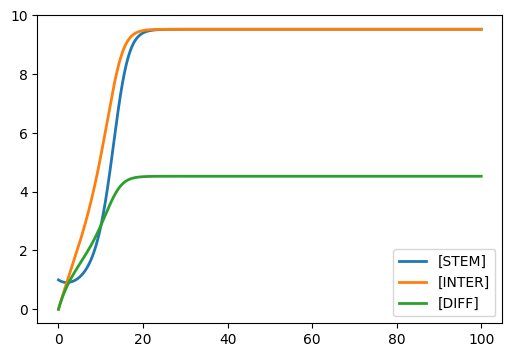

In [9]:
model = threeCompartmentModel(
  STEM='1', INTER='0', DIFF='0', 
  LS='0.5',PS='.5',LI='.5',PI='.5',D='0.1',
  Control=[inhib['komorova']('STEM','5'), inhib['komorova']('INTER','5'), '1', inhib['komorova']('DIFF','5'),],
  Events=[])

r = te.loada(model)
r.simulate(0, 100, 10000)
r.plot()